In [3]:
from astropy.table import Table, join
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from astropy.coordinates import SkyCoord, match_coordinates_sky
import astropy.units as u
from matplotlib import cm
import time
from numpy.random import default_rng

import healpy as hp
import pymaster as nmt
import pandas as pd

import sys
sys.path.insert(0,'../code')
%load_ext autoreload
%autoreload 2
import utils
import generate_random
import correlations

In [4]:
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['xtick.labelsize'] = 18
matplotlib.rcParams['axes.labelsize'] = 22
matplotlib.rcParams['legend.fontsize'] = 18

matplotlib.rc('text', usetex=True)

In [5]:
rng = default_rng(seed=42)

In [4]:
l = np.arange(-180,180,1)
b = np.arange(-90,90,1)
l_grid, b_grid = np.meshgrid(l, b)
c = SkyCoord(l=l_grid*u.degree, b=b_grid*u.degree, frame='galactic')
l_arr = l_grid.flatten()
b_arr = b_grid.flatten()

#the map is in (ra,dec) so we need to convert:
ra = c.icrs.ra.degree.flatten() 
dec = c.icrs.dec.degree.flatten() 

In [5]:
def plot_completeness(l, b, completeness, title=None):
    plt.figure(figsize=(8,6))
    plt.title(title)
    plt.scatter( l, b, c=completeness , vmin=0.8, vmax=1,s=1)
    plt.colorbar(label='completeness')
    plt.xlim(180,-180)
    plt.ylim(-90, 90)
    plt.xlabel('l (degrees)')
    plt.ylabel('b (degrees)')
    plt.show()

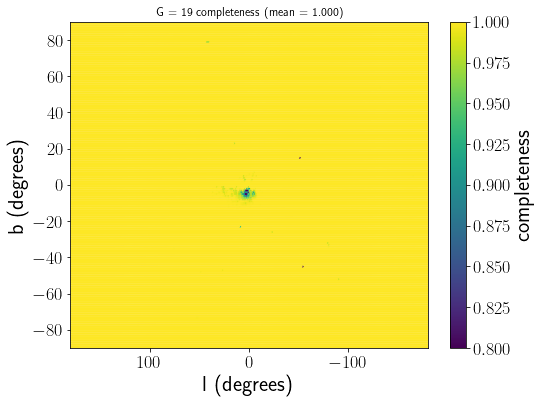

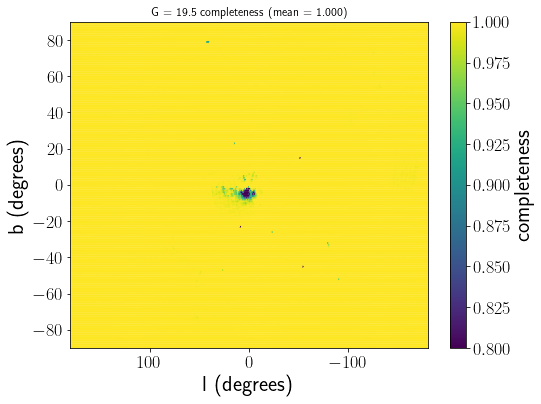

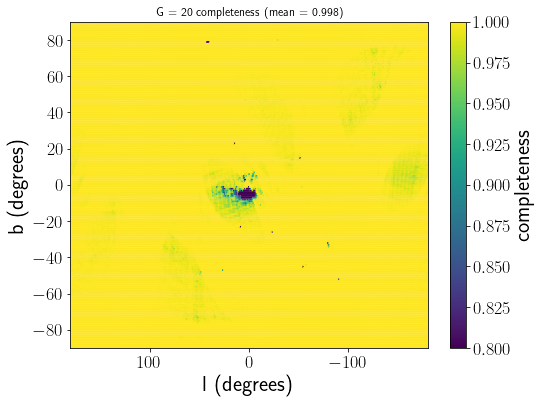

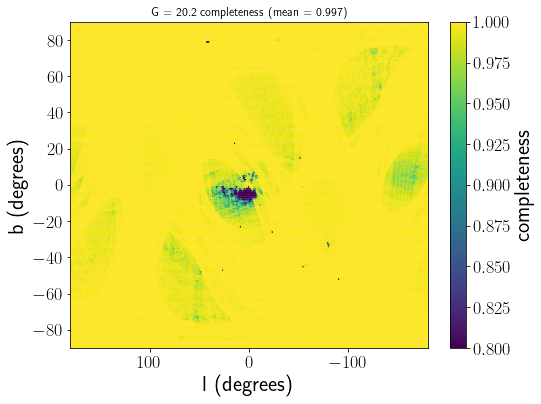

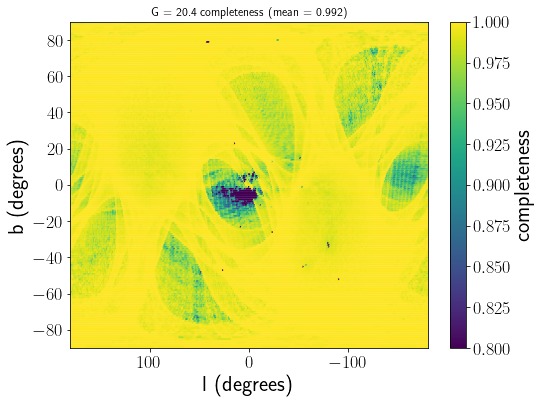

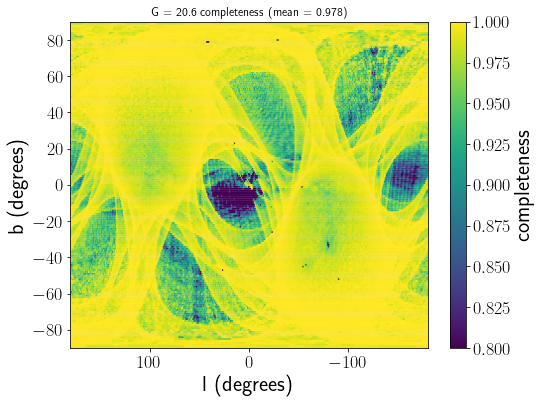

In [6]:
gmag_lims = [19, 19.5, 20, 20.2, 20.4, 20.6]
for gmag in gmag_lims:
    completeness = utils.get_completeness(ra, dec, gmag)
    title = f'G = {gmag} completeness (mean = {np.mean(completeness):.3f})'
    plot_completeness(l_arr, b_arr, completeness, title=title)

Uniform random on sphere (idk if l and b are uniform?? maybe not?)

In [7]:
N_sphere = int(1e6)
ra_sphere, dec_sphere = utils.random_ra_dec_on_sphere(rng, N_sphere)

NPIX: 49152


0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0
0.0 180.0 -180.0 180.0


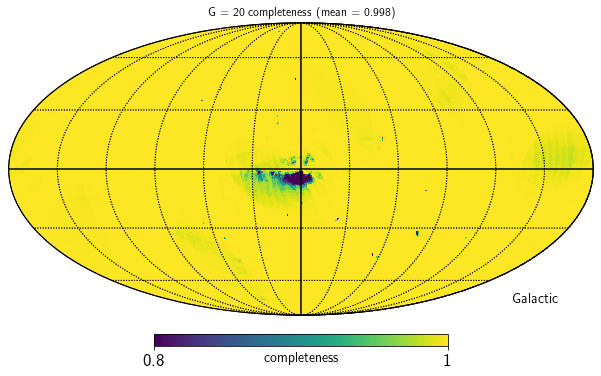

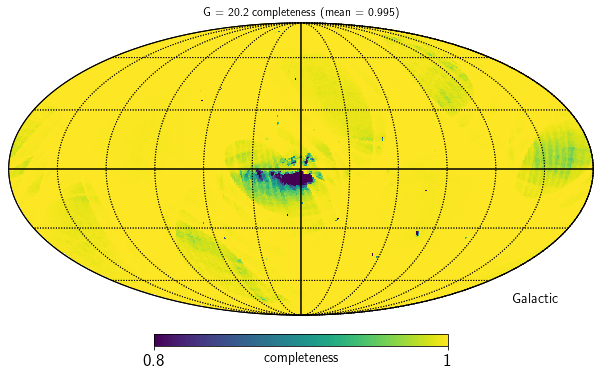

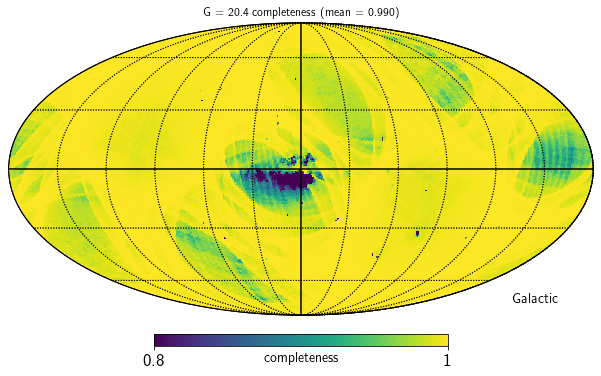

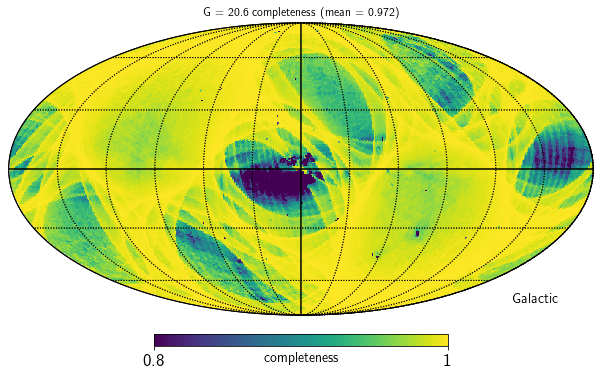

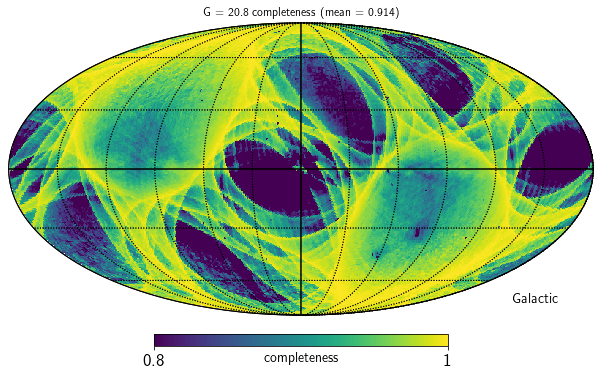

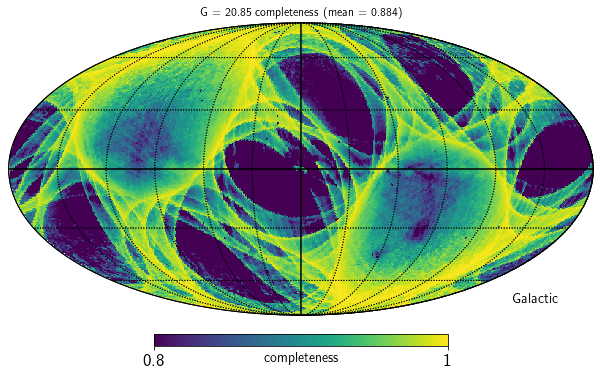

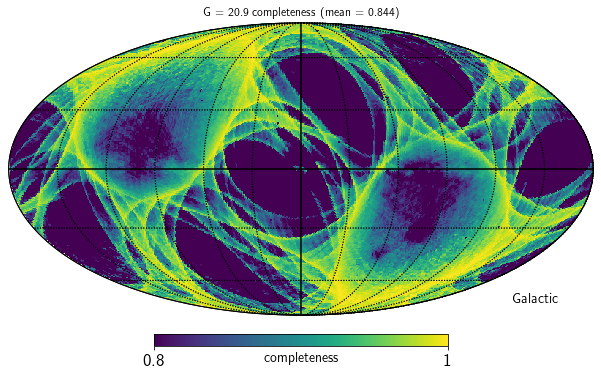

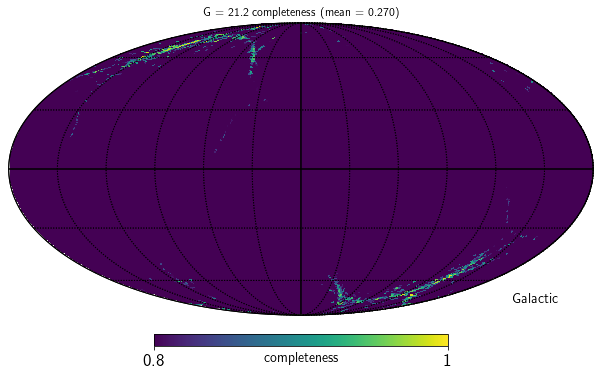

In [8]:
NSIDE = 64
NPIX = hp.nside2npix(NSIDE)
print(f"NPIX: {NPIX}")
gmag_lims = [20, 20.2, 20.4, 20.6, 20.8, 20.85, 20.9, 21.2]
for gmag in gmag_lims:
    gmags = np.full(len(ra_sphere), gmag)
    completeness = utils.get_completeness(ra_sphere, dec_sphere, gmags)
    title = f'G = {gmag} completeness (mean = {np.mean(completeness):.3f})'
    map_comp, _ = utils.get_map(64, ra_sphere, dec_sphere, quantity=completeness, func_name='mean',
            null_val=np.nan)

    hp.mollview(map_comp, title=title, unit=r"completeness",
                cmap='viridis', coord=['C', 'G'], min=0.8, max=1)
    hp.graticule()
    #I = np.random.uniform(size=len(ra_sphere)) < completeness
    #map_n, _ = utils.get_map(64, ra_sphere[I], dec_sphere[I], func_name='count',
    #        null_val=0)
    #hp.mollview(map_n, title=title, unit=r"completeness",
    #            cmap='viridis', coord=['C', 'G'])#, min=0, max=1)
    hp.graticule()

# Completeness vs number density

## Load in data

In [6]:
NSIDE = 64
area_per_pixel = hp.pixelfunc.nside2pixarea(NSIDE, degrees=True)

In [7]:
fn_gaia = '../data/gaia_spz_kNN.fits'
tab_gaia = utils.load_table(fn_gaia)
N_data = len(tab_gaia)
ra_data, dec_data, gmag_data = tab_gaia['ra'], tab_gaia['dec'], tab_gaia['phot_g_mean_mag']
print(f"Number of data sources: {N_data}")

Number of data sources: 648842


In [8]:
map_nqso_data, pixel_indices_data = utils.get_map(NSIDE, ra_data, dec_data, null_val=0)

0.0 180.0 -180.0 180.0


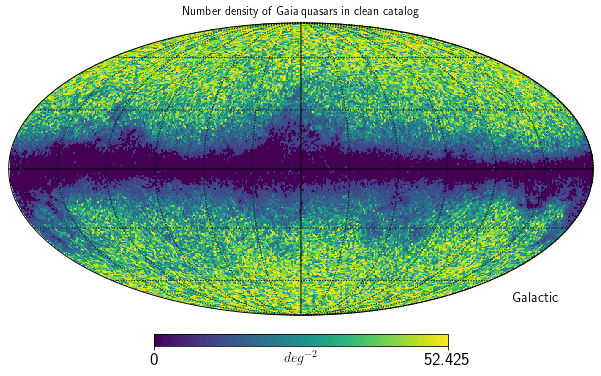

In [9]:
hp.mollview(map_nqso_data/area_per_pixel, title=rf"Number density of Gaia quasars in clean catalog",
            unit=r"$deg^{-2}$", cmap='viridis', coord=['C', 'G'], min=0, max=10)
hp.graticule()

## m10 healpix map

In [10]:
map_m10 = utils.get_m10_map(NSIDE)

Generating new dust map (None
NPIX for dust map sampling: 50331648


0.0 180.0 -180.0 180.0


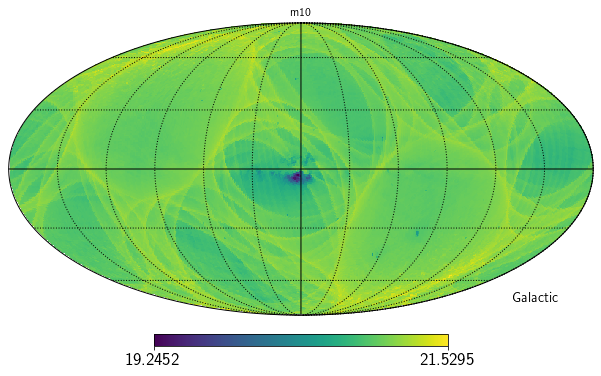

In [12]:
hp.mollview(map_m10, title=rf"m10",
            unit=r"", cmap='viridis', coord=['C', 'G'])
hp.graticule()

## Fit m10 vs number density

In [26]:
bins_m10 = np.linspace(np.min(map_m10), np.max(map_m10), 40)
bins_nqso = np.arange(0, np.ceil(np.max(map_nqso_data)), 1)

Text(0, 0.5, 'number of Gaia QSOs')

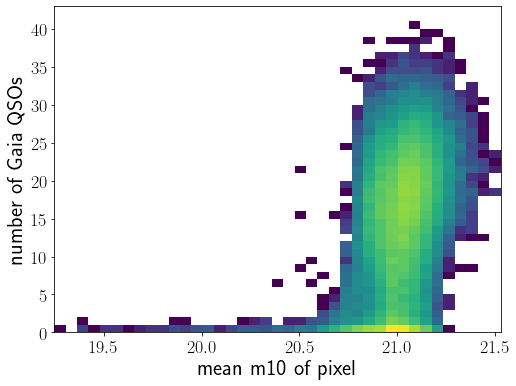

In [30]:
map_nqso_data

plt.figure(figsize=(8,6))

plt.hist2d(map_m10, map_nqso_data, bins=[bins_m10, bins_nqso], norm=matplotlib.colors.LogNorm(), )
#plt.plot(map_av_rand[idx_av_sorted], p_Av[idx_av_sorted], color='orange', lw=3, label='Best fit exponential')

#plt.xscale('log')
#plt.yscale('log')
#plt.xlim(0, 3)
plt.xlabel(r'mean m10 of pixel')
plt.ylabel('number of Gaia QSOs')

## Show dust as additional dimension

In [31]:
fn_dustmap = f'../data/dustmap_Avmean_NSIDE{NSIDE}.npy'
map_avmean = utils.get_dust_map(None, None, fn_dustmap=fn_dustmap)

Dustmap already exists, loading from ../data/dustmap_Avmean_NSIDE64.npy


(0.0, 50.0)

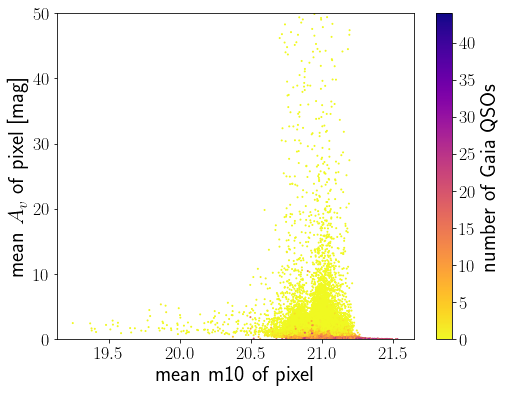

In [44]:
plt.figure(figsize=(8,6))

plt.scatter(map_m10, map_avmean, c=map_nqso_data, cmap='plasma_r', s=1, vmin=0)
plt.colorbar(label='number of Gaia QSOs')

plt.xlabel('mean m10 of pixel')
plt.ylabel(r'mean $A_v$ of pixel [mag]')

plt.ylim(0, 50)

(0.0, 1.0)

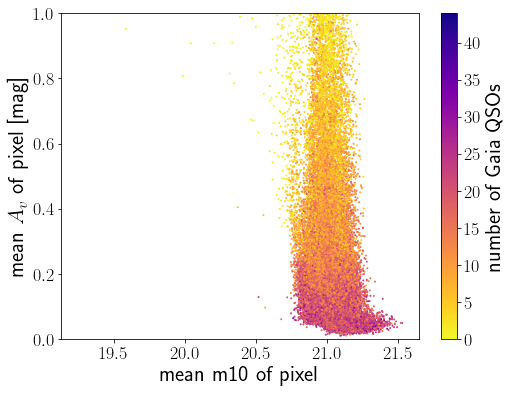

In [42]:
plt.figure(figsize=(8,6))

plt.scatter(map_m10, map_avmean, c=map_nqso_data, cmap='plasma_r', s=1, vmin=0)
plt.colorbar(label='number of Gaia QSOs')

plt.xlabel('mean m10 of pixel')
plt.ylabel(r'mean $A_v$ of pixel [mag]')
plt.ylim(0, 1)